In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, anderson
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [5]:
data = pd.read_csv('emission_data_preprocessed.csv')

In [6]:
data

,Unnamed: 0,year,parent_entity,parent_type,commodity,production_value,production_unit,total_emissions_MtCO2e,emission_intensity
0,0,1962,Abu Dhabi National Oil Company,State-owned Entity,Oil & NGL,0.91250,Million bbl/yr,0.363885,0.398778
1,1,1962,Abu Dhabi National Oil Company,State-owned Entity,Natural Gas,1.84325,Bcf/yr,0.134355,0.072890
2,2,1963,Abu Dhabi National Oil Company,State-owned Entity,Oil & NGL,1.82500,Million bbl/yr,0.727770,0.398778
3,3,1963,Abu Dhabi National Oil Company,State-owned Entity,Natural Gas,4.42380,Bcf/yr,0.322453,0.072890
4,4,1964,Abu Dhabi National Oil Company,State-owned Entity,Oil & NGL,7.30000,Million bbl/yr,2.911079,0.398778
...,...,...,...,...,...,...,...,...,...
12546,12546,2020,YPF,State-owned Entity,Natural Gas,394.00000,Bcf/yr,28.718814,0.072890
12547,12547,2021,YPF,State-owned Entity,Oil & NGL,90.00000,Million bbl/yr,35.890011,0.398778
12548,12548,2021,YPF,State-owned Entity,Natural Gas,403.00000,Bcf/yr,29.374827,0.072890
12549,12549,2022,YPF,State-owned Entity,Oil & NGL,98.00000,Million bbl/yr,39.080234,0.398778


In [7]:
categorical_features = ['parent_entity', 'parent_type', 'commodity']
numerical_features = ['year', 'production_value', 'emission_intensity']

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ])

In [9]:
drop_cols = ['total_emissions_MtCO2e', 'Unnamed: 0']

In [10]:
X = data.drop(drop_cols, axis=1)
y = data['total_emissions_MtCO2e']

In [11]:
data.columns

Index(['Unnamed: 0', 'year', 'parent_entity', 'parent_type', 'commodity',
       'production_value', 'production_unit', 'total_emissions_MtCO2e',
       'emission_intensity'],
      dtype='object')

In [12]:
X

,year,parent_entity,parent_type,commodity,production_value,production_unit,emission_intensity
0,1962,Abu Dhabi National Oil Company,State-owned Entity,Oil & NGL,0.91250,Million bbl/yr,0.398778
1,1962,Abu Dhabi National Oil Company,State-owned Entity,Natural Gas,1.84325,Bcf/yr,0.072890
2,1963,Abu Dhabi National Oil Company,State-owned Entity,Oil & NGL,1.82500,Million bbl/yr,0.398778
3,1963,Abu Dhabi National Oil Company,State-owned Entity,Natural Gas,4.42380,Bcf/yr,0.072890
4,1964,Abu Dhabi National Oil Company,State-owned Entity,Oil & NGL,7.30000,Million bbl/yr,0.398778
...,...,...,...,...,...,...,...
12546,2020,YPF,State-owned Entity,Natural Gas,394.00000,Bcf/yr,0.072890
12547,2021,YPF,State-owned Entity,Oil & NGL,90.00000,Million bbl/yr,0.398778
12548,2021,YPF,State-owned Entity,Natural Gas,403.00000,Bcf/yr,0.072890
12549,2022,YPF,State-owned Entity,Oil & NGL,98.00000,Million bbl/yr,0.398778


In [13]:
y

0         0.363885
1         0.134355
2         0.727770
3         0.322453
4         2.911079
           ...    
12546    28.718814
12547    35.890011
12548    29.374827
12549    39.080234
12550    30.832635
Name: total_emissions_MtCO2e, Length: 12551, dtype: float64

In [14]:
X = preprocessor.fit_transform(X)

In [15]:
X

array([[-0.86119873, -0.30332949, -0.6430239 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.86119873, -0.30264385, -0.93459097, ...,  0.        ,
         0.        ,  0.        ],
       [-0.82695367, -0.30265729, -0.6430239 , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.15925981, -0.00712896, -0.93459097, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.19350487, -0.23180931, -0.6430239 , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.19350487,  0.00760418, -0.93459097, ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [18]:
X_train

tensor([[ 3.7162e-01,  1.3900e+01, -9.3459e-01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.2379e+00, -2.7616e-01,  1.4285e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.0722e-03, -2.8503e-01,  1.9837e-01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-5.1875e-01, -2.8632e-01, -9.3459e-01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-7.5846e-01, -3.0190e-01,  1.6106e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 9.1954e-01, -7.5859e-02, -9.3459e-01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

In [19]:
# Convert sparse matrix to dense matrix if needed
if hasattr(X, "toarray"):
    X = X.toarray()

In [20]:
X

array([[-0.86119873, -0.30332949, -0.6430239 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.86119873, -0.30264385, -0.93459097, ...,  0.        ,
         0.        ,  0.        ],
       [-0.82695367, -0.30265729, -0.6430239 , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.15925981, -0.00712896, -0.93459097, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.19350487, -0.23180931, -0.6430239 , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.19350487,  0.00760418, -0.93459097, ...,  0.        ,
         0.        ,  0.        ]])

In [47]:
# Define the dataset class
class EmissionsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [48]:
# Create DataLoader
train_dataset = EmissionsDataset(X_train, y_train)
test_dataset = EmissionsDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [49]:
for idx, batch in enumerate(train_loader):
  print(batch[idx])
  break

tensor([[ 1.0565, -0.2588, -0.6430,  ...,  1.0000,  0.0000,  0.0000],
        [-1.4434, -0.2976,  1.1201,  ...,  0.0000,  0.0000,  1.0000],
        [-0.0736, -0.2210,  1.4285,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.9880, -0.2953,  1.1201,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.4744, -0.2000, -0.6430,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.8853,  1.4721, -0.5525,  ...,  0.0000,  0.0000,  0.0000]])


In [50]:
# Define the neural network
class EmissionsModel(nn.Module):
    def __init__(self, input_dim):
        super(EmissionsModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [51]:
input_dim = X_train.shape[1]
model = EmissionsModel(input_dim)

In [52]:
input_dim

137

In [53]:
model

EmissionsModel(
  (fc1): Linear(in_features=137, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [54]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
train_losses = []
val_losses = []

In [56]:
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        if inputs.size(0) == 1:  # Skip batches with only one sample
            continue
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Gradient clipping
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item()

    epoch_val_loss /= len(test_loader)
    val_losses.append(epoch_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')


Epoch 1/40, Train Loss: 120724.1144, Val Loss: 90886.8668
Epoch 2/40, Train Loss: 108373.2386, Val Loss: 74265.4560
Epoch 3/40, Train Loss: 95292.1971, Val Loss: 62250.9687
Epoch 4/40, Train Loss: 83830.9603, Val Loss: 54424.4388
Epoch 5/40, Train Loss: 73764.6412, Val Loss: 43358.9602
Epoch 6/40, Train Loss: 66947.1396, Val Loss: 32873.3377
Epoch 7/40, Train Loss: 64089.1752, Val Loss: 27882.4706
Epoch 8/40, Train Loss: 59039.3700, Val Loss: 26260.7299
Epoch 9/40, Train Loss: 55189.4620, Val Loss: 25491.0167
Epoch 10/40, Train Loss: 53082.6481, Val Loss: 27439.7082
Epoch 11/40, Train Loss: 52575.2992, Val Loss: 25524.6981
Epoch 12/40, Train Loss: 50554.0241, Val Loss: 22305.5109
Epoch 13/40, Train Loss: 47455.5234, Val Loss: 22802.8541
Epoch 14/40, Train Loss: 46506.6966, Val Loss: 19728.7776
Epoch 15/40, Train Loss: 45599.5679, Val Loss: 20231.6573
Epoch 16/40, Train Loss: 43003.5987, Val Loss: 11500.2052
Epoch 17/40, Train Loss: 42899.6637, Val Loss: 21699.1594
Epoch 18/40, Train Lo

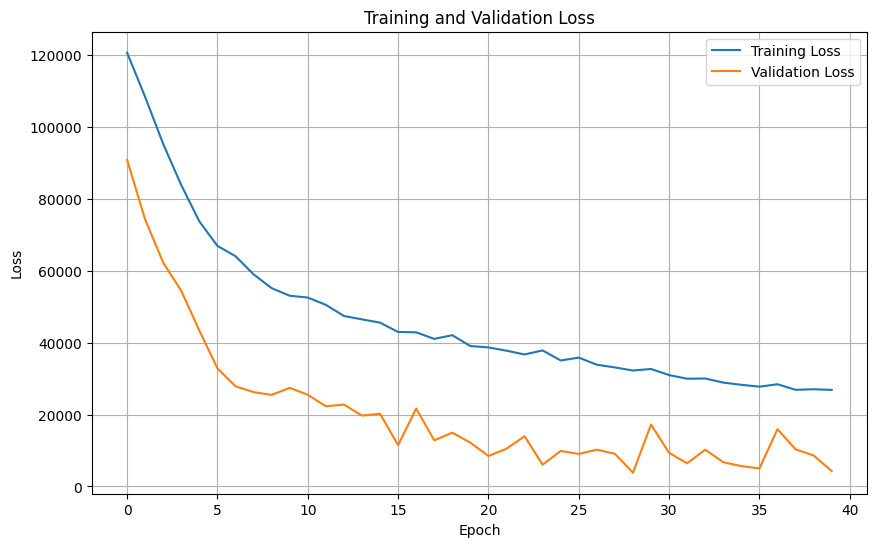

In [57]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# Forecast future emissions (example for the next 10 years)
future_years = np.arange(2023, 2033)
future_data = pd.DataFrame({
    'year': future_years,
    'parent_entity': ['Former Soviet Union'] * len(future_years),
    'parent_type': ['Nation State'] * len(future_years),
    'commodity': ['Lignite Coal'] * len(future_years),
    'production_value': [0.03] * len(future_years),  # Example production values
    'emission_intensity': [0.4] * len(future_years)  # Example emission intensities
})

In [64]:
future_data = preprocessor.transform(future_data)
future_data = torch.tensor(future_data, dtype=torch.float32)

# Make predictions
model.eval()
with torch.no_grad():
    future_predictions = model(future_data)

print(future_predictions)

tensor([[3.6072],
        [3.8058],
        [3.9719],
        [4.1161],
        [4.2603],
        [4.4044],
        [4.6156],
        [4.9686],
        [5.4356],
        [5.9112]])


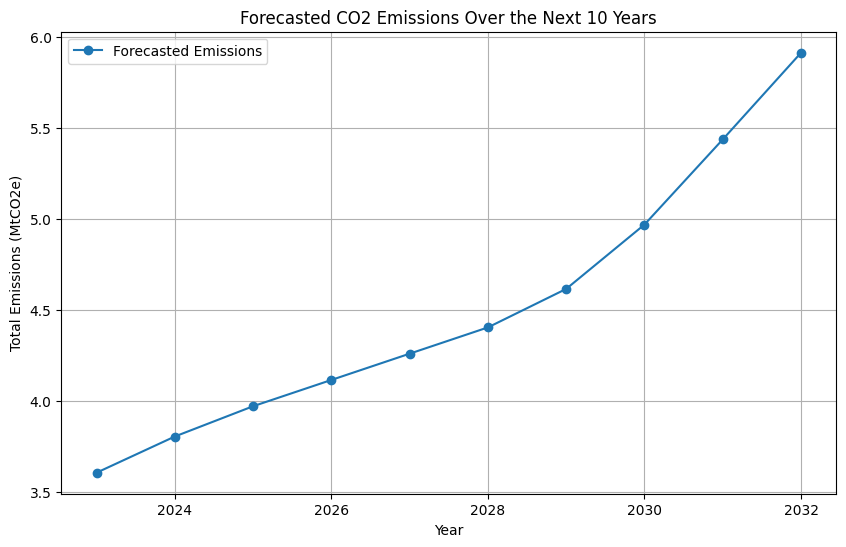

In [65]:
# Plotting the forecasted emissions
plt.figure(figsize=(10, 6))
plt.plot(future_years, future_predictions, label='Forecasted Emissions', marker='o')
plt.xlabel('Year')
plt.ylabel('Total Emissions (MtCO2e)')
plt.title('Forecasted CO2 Emissions Over the Next 10 Years')
plt.legend()
plt.grid(True)
plt.show()